# **Judul: Analisis Perbandingan Model Bi-LSTM dan IndoBERT untuk Klasifikasi Emosi Ulasan Aplikasi AHM Mobile Periode 2020 hingga 2024**

# **Import Library yang dibutuhkan dalam menjalankan Model BERT**

In [ ]:
!git clone https://github.com/indobenchmark/indonlu

!pip install emoji
!pipi install transformers
!pip install -q transformers datasets emoji google-play-scraper stanza
!pip install transformers torch

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from collections import defaultdict

#NLP
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import emoji

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

fatal: destination path 'indonlu' already exists and is not an empty directory.
/bin/bash: line 1: pipi: command not found


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('there are %d GPU(s) available.'%torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


# **Scrapper Data**

In [ ]:
# Install library google play store untuk scrapping data
!pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Import libary yang diperlukan
from google_play_scraper import app
import pandas as pd
import numpy as np
from google_play_scraper import Sort, reviews
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Parameter aplikasi dan rentang waktu
app_id = 'com.ahm.hr'
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 31)

# Variabel untuk menyimpan hasil
all_reviews = [] # Menyimpan semua ulasan yang berhasil diambil dari Google Play Store
token = None # Untuk melanjutkan pengambilan ulasan jika ada lebih banyak data yang perlu diambil
done = False # Indikator untuk menghentikan loop pengambilan data
print("Mengambil ulasan dari Google Play Store...")

# Loop untuk ambil semua ulasan hingga sebelum 2020
while not done:
    result, token = reviews(
        app_id,
        lang='id',            # Bahasa Indonesia
        country='id',         # Wilayah Indonesia
        sort=Sort.NEWEST,     # Mulai dari ulasan terbaru
        continuation_token=token
    )

    for review in result:
        review_date = review['at']
        if start_date <= review_date <= end_date:
            all_reviews.append(review)
        elif review_date < start_date:
            done = True
            break

    if token is None:
        break

# Konversi ke DataFrame
df_ahm = pd.DataFrame(all_reviews)

# Tampilkan hasil
print(f"Total ulasan ditemukan: {len(df_ahm)}")
df_ahm

Mengambil ulasan dari Google Play Store...
Total ulasan ditemukan: 1230


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,fbdc995b-a3f0-4072-89e7-7f066f4e5008,Meygi Tri,https://play-lh.googleusercontent.com/a-/ALV-U...,Tolong lah ya sekelas AHM masa servernya berat...,1,0,5.9.6,2024-11-19 02:12:16,None,NaT,5.9.6
1,fb7fb9c8-a291-47b5-a70e-d45dc7498f20,Marjedad ID,https://play-lh.googleusercontent.com/a-/ALV-U...,Ketika lupa password dan sudah direset tidak b...,1,32,5.9.6,2024-10-24 09:41:05,None,NaT,5.9.6
2,337f4a2b-1948-4ff1-90f8-e4be28bb1316,Laela Qurotul aeni09,https://play-lh.googleusercontent.com/a-/ALV-U...,Mantap,5,0,None,2024-10-16 14:15:09,None,NaT,None
3,a99d431c-789f-4665-85d1-4bd05e00fdf8,Badsoeki,https://play-lh.googleusercontent.com/a-/ALV-U...,Password gagal diperbaharui -_-,1,0,5.9.6,2024-10-03 06:48:00,None,NaT,5.9.6
4,2ea63b15-c007-4391-be49-82f3754117b0,Fu Mledink,https://play-lh.googleusercontent.com/a/ACg8oc...,Tolong dong jangan dikit² logout. Ganti paswor...,3,2,5.9.6,2024-09-26 11:08:16,None,NaT,5.9.6
...,...,...,...,...,...,...,...,...,...,...,...
1225,966ac205-255c-419d-aa9a-09303ff62861,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kurang,1,0,5.3.0,2020-01-02 00:45:58,None,NaT,5.3.0
1226,5df8f36a-5d79-419a-86ea-eb787db9dea7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Salam satu hati,5,0,5.3.1,2020-01-01 23:01:39,None,NaT,5.3.1
1227,20df5018-9b69-46b8-a11f-b49e1bc771f5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Mantap sekalii,5,0,5.3.0,2020-01-01 15:55:07,None,NaT,5.3.0
1228,a929b4ed-f855-404c-90a3-2cea043cf3bf,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ajib,5,0,5.3.0,2020-01-01 12:01:25,None,NaT,5.3.0


# **Exploratory Data Analysis (EDA)**

In [ ]:
# Menampilkan karakteristik data
df_ahm.info()
df_ahm.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1230 non-null   object        
 1   userName              1230 non-null   object        
 2   userImage             1230 non-null   object        
 3   content               1230 non-null   object        
 4   score                 1230 non-null   int64         
 5   thumbsUpCount         1230 non-null   int64         
 6   reviewCreatedVersion  1024 non-null   object        
 7   at                    1230 non-null   datetime64[ns]
 8   replyContent          17 non-null     object        
 9   repliedAt             17 non-null     datetime64[ns]
 10  appVersion            1024 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 105.8+ KB


,score,thumbsUpCount,at,repliedAt
count,1230.000000,1230.000000,1230,17
mean,2.703252,1.503252,2021-07-22 18:01:42.947154432,2018-03-22 17:35:47.705882624
min,1.000000,0.000000,2020-01-01 04:37:05,2017-06-12 09:11:15
25%,1.000000,0.000000,2020-05-02 17:45:30.500000,2017-08-30 04:35:57
50%,2.000000,0.000000,2021-12-02 07:16:55,2018-07-25 05:30:36
75%,5.000000,0.000000,2022-04-13 05:30:30.500000,2018-09-03 00:37:04
max,5.000000,92.000000,2024-11-19 02:12:16,2018-10-17 13:01:02
std,1.790647,6.734020,NaN,NaN


In [ ]:
# Mengecek duplikasi data
print("Jumlah data duplikat:", df_ahm.duplicated().sum())

Jumlah data duplikat: 0


In [ ]:
# Mengecek missing value
print("Jumlah missing value:")
df_ahm.isna().sum()

Jumlah missing value:


,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,206
at,0
replyContent,1213
repliedAt,1213


In [ ]:
df_ahm = df_ahm.drop(columns=['reviewId', 'userName', 'userImage', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
                              'replyContent', 'repliedAt', 'appVersion'])
df_ahm = df_ahm[['at', 'content']]
df_ahm

,at,content
0,2024-11-19 02:12:16,Tolong lah ya sekelas AHM masa servernya berat...
1,2024-10-24 09:41:05,Ketika lupa password dan sudah direset tidak b...
2,2024-10-16 14:15:09,Mantap
3,2024-10-03 06:48:00,Password gagal diperbaharui -_-
4,2024-09-26 11:08:16,Tolong dong jangan dikit² logout. Ganti paswor...
...,...,...
1225,2020-01-02 00:45:58,Kurang
1226,2020-01-01 23:01:39,Salam satu hati
1227,2020-01-01 15:55:07,Mantap sekalii
1228,2020-01-01 12:01:25,Ajib


In [ ]:
# Simpan DataFrame df_ahm sebagai file CSV
df_ahm.to_csv('ulasan_ahm_mobile_2020-2024.csv', index=False)

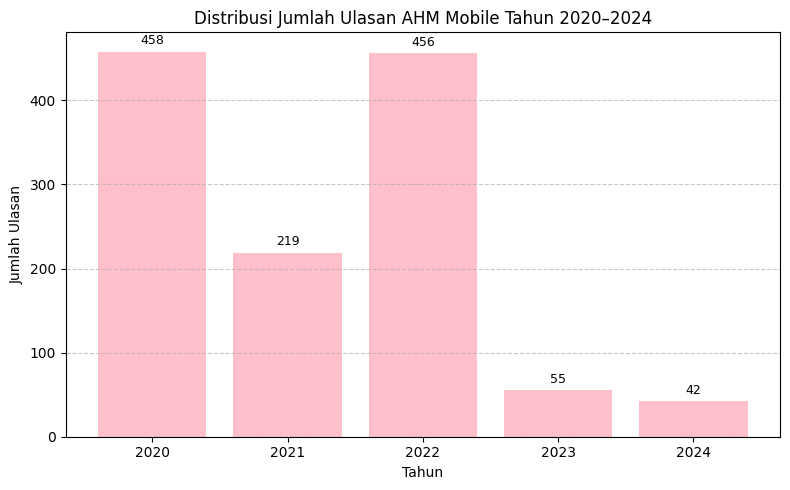

In [ ]:
import matplotlib.pyplot as plt

# Kolom tanggal bernama 'at' dan bertipe datetime
df_ahm['at'] = pd.to_datetime(df_ahm['at'])

# Ambil tahun dari kolom 'at'
df_ahm['year'] = df_ahm['at'].dt.year

# Filter tahun 2020–2024
df_filtered_years = df_ahm[df_ahm['year'].between(2020, 2024)]

# Hitung jumlah ulasan per tahun
content_per_year = df_filtered_years['year'].value_counts().sort_index()

# Visualisasi
plt.figure(figsize=(8, 5))
bars = plt.bar(content_per_year.index.astype(str), content_per_year.values, color='pink')
plt.title('Distribusi Jumlah Ulasan AHM Mobile Tahun 2020–2024')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Ulasan')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label jumlah di atas tiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# **Input Dataset Label Manual**

In [ ]:
# Langkah 1: Upload file dari lokal
from google.colab import files
uploaded = files.upload()

# Langkah 2: Import pustaka pandas
import pandas as pd

# Langkah 3: Baca file CSV (ganti 'nama_file.csv' dengan nama file yang diupload)
# Secara otomatis, files.upload() menyimpan file dalam dictionary
import io

# Ambil nama file dari dictionary
filename = next(iter(uploaded))

# Baca CSV ke DataFrame
df_ahm = pd.read_csv(io.BytesIO(uploaded[filename]))

# Langkah 4: Tampilkan data
print("Data berhasil diimport:")
df_ahm


Saving ulasan_ahm_mobile_hasillabelling_2020-2024 - Manual.csv to ulasan_ahm_mobile_hasillabelling_2020-2024 - Manual.csv
Data berhasil diimport:


,at,content,emotion_label
0,2024-11-19 2:12:16,Tolong lah ya sekelas AHM masa servernya berat...,muak
1,2024-10-24 9:41:05,Ketika lupa password dan sudah direset tidak b...,muak
2,2024-10-16 14:15:09,Mantap,senang
3,2024-10-03 6:48:00,Password gagal diperbaharui -_-,muak
4,2024-09-26 11:08:16,Tolong dong jangan dikit² logout. Ganti paswor...,marah
...,...,...,...
1225,2020-01-02 0:45:58,Kurang,netral
1226,2020-01-01 23:01:39,Salam satu hati,netral
1227,2020-01-01 15:55:07,Mantap sekalii,senang
1228,2020-01-01 12:01:25,Ajib,senang


# **Encode Label**

In [ ]:
# Mapping label ke angka
label2id = {
    'senang': 0,
    'sedih': 1,
    'marah': 2,
    'takut': 3,
    'netral': 4,
    'muak': 5
}

# Buat kolom label_encoded
df_ahm['label_encoded'] = df_ahm['emotion_label'].map(label2id)

# Tambahkan kolom baru ke dalam urutan tampilan
ordered_columns = [
    'at', 'content', 'emotion_label', 'label_encoded'
]
df_ahm = df_ahm[ordered_columns]
df_ahm

,at,content,emotion_label,label_encoded
0,2024-11-19 2:12:16,Tolong lah ya sekelas AHM masa servernya berat...,muak,5
1,2024-10-24 9:41:05,Ketika lupa password dan sudah direset tidak b...,muak,5
2,2024-10-16 14:15:09,Mantap,senang,0
3,2024-10-03 6:48:00,Password gagal diperbaharui -_-,muak,5
4,2024-09-26 11:08:16,Tolong dong jangan dikit² logout. Ganti paswor...,marah,2
...,...,...,...,...
1225,2020-01-02 0:45:58,Kurang,netral,4
1226,2020-01-01 23:01:39,Salam satu hati,netral,4
1227,2020-01-01 15:55:07,Mantap sekalii,senang,0
1228,2020-01-01 12:01:25,Ajib,senang,0


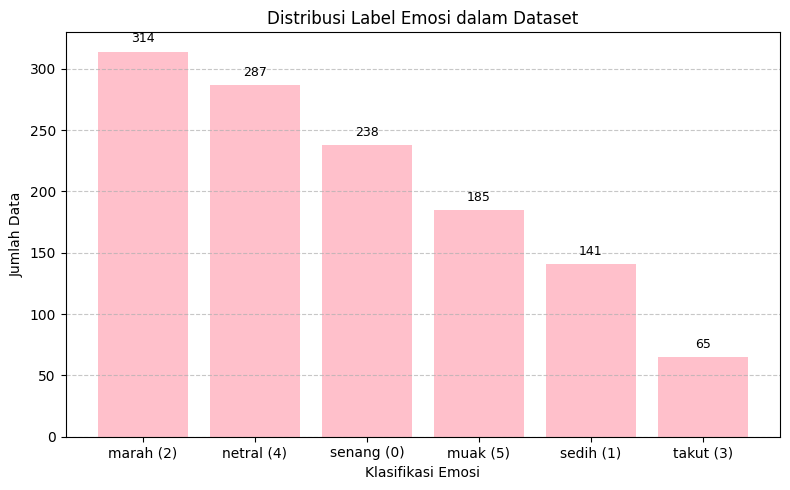

In [ ]:
import matplotlib.pyplot as plt

# Mapping label emosi ke label numerik
label_mapping = {
    'senang': 'senang (0)',
    'sedih': 'sedih (1)',
    'marah': 'marah (2)',
    'takut': 'takut (3)',
    'netral': 'netral (4)',
    'muak': 'muak (5)'
}

# Hitung distribusi emosi dan map ke label numerik
emotion_counts_raw = df_ahm['emotion_label'].value_counts()
emotion_counts = {label_mapping[k]: v for k, v in emotion_counts_raw.items()}

# Urutkan berdasarkan jumlah tertinggi ke terendah
emotion_counts = dict(sorted(emotion_counts.items(), key=lambda item: item[1], reverse=True))

# Membuat plot batang
plt.figure(figsize=(8, 5))
bars = plt.bar(emotion_counts.keys(), emotion_counts.values(), color='pink')
plt.title('Distribusi Label Emosi dalam Dataset')
plt.xlabel('Klasifikasi Emosi')
plt.ylabel('Jumlah Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan nilai di atas setiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, str(height),
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# Simpan DataFrame df_ahm sebagai file CSV
df_ahm.to_csv('ulasan_ahm_mobile_hasilencode_2020-2024.csv', index=False)

# **Fine-Tune IndoBERT**

In [ ]:
# Mapping label string ke angka
label2id = {
    'senang': 0,
    'sedih': 1,
    'marah': 2,
    'takut': 3,
    'netral': 4,
    'muak': 5
}

# Pastikan kolom emosi sudah di-mapping
df_ahm['label_encoded'] = df_ahm['emotion_label'].map(label2id)

# Ambil hanya kolom yang dibutuhkan dan pastikan nama kolom sesuai
df_finetune = df_ahm[['content', 'label_encoded']].copy()
df_finetune.columns = ['text', 'label']  # Rename kolom

# Split dan simpan
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_finetune, test_size=0.3, stratify=df_finetune['label'], random_state=42)

import os
os.makedirs("data", exist_ok=True)
train_df.to_csv("data/train.csv", index=False)
val_df.to_csv("data/valid.csv", index=False)


In [ ]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Dataset class
class DocumentSentimentDataset(Dataset):
    def __init__(self, dataset_path, tokenizer, max_length=128):
        df = pd.read_csv(dataset_path)
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load dataset dan DataLoader
train_dataset = DocumentSentimentDataset("data/train.csv", tokenizer)
val_dataset = DocumentSentimentDataset("data/valid.csv", tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [ ]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

train_dataset = DocumentSentimentDataset("data/train.csv", tokenizer)
val_dataset = DocumentSentimentDataset("data/valid.csv", tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=6
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from indonlu.utils.metrics import document_sentiment_metrics_fn
from tqdm import tqdm

def custom_forward_sequence_classification(model, data_loader, optimizer=None, train=True, device=None):
    model.train() if train else model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(data_loader, desc="Training" if train else "Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if train:
            optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    return avg_loss, all_preds, all_labels

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

for epoch in range(5):
    print(f"\nEpoch {epoch+1} [IndoBERT]")

    # Training IndoBERT
    train_loss, train_preds, train_labels = custom_forward_sequence_classification(
        model, train_loader, optimizer=optimizer, train=True, device=device
    )
    train_acc = accuracy_score(train_labels, train_preds)
    train_macro_f1 = f1_score(train_labels, train_preds, average='macro')
    train_micro_f1 = f1_score(train_labels, train_preds, average='micro')
    print(f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Micro-F1: {train_micro_f1:.4f} | Macro-F1: {train_macro_f1:.4f}")

    # Validation IndoBERT
    val_loss, val_preds_bert, val_labels_bert = custom_forward_sequence_classification(
        model, val_loader, optimizer=None, train=False, device=device
    )
    val_acc = accuracy_score(val_labels_bert, val_preds_bert)
    val_macro_f1 = f1_score(val_labels_bert, val_preds_bert, average='macro')
    val_micro_f1 = f1_score(val_labels_bert, val_preds_bert, average='micro')
    print(f"[Val]   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Micro-F1: {val_micro_f1:.4f} | Macro-F1: {val_macro_f1:.4f}")


Epoch 1 [IndoBERT]


Training: 100%|██████████| 54/54 [00:18<00:00,  2.99it/s]


[Train] Loss: 1.5809 | Acc: 0.3891 | Micro-F1: 0.3891 | Macro-F1: 0.2427


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.77it/s]


[Val]   Loss: 1.3782 | Acc: 0.4715 | Micro-F1: 0.4715 | Macro-F1: 0.3058

Epoch 2 [IndoBERT]


Training: 100%|██████████| 54/54 [00:18<00:00,  2.91it/s]


[Train] Loss: 1.2513 | Acc: 0.5482 | Micro-F1: 0.5482 | Macro-F1: 0.3716


Evaluating: 100%|██████████| 24/24 [00:03<00:00,  7.80it/s]


[Val]   Loss: 1.1998 | Acc: 0.5393 | Micro-F1: 0.5393 | Macro-F1: 0.3899

Epoch 3 [IndoBERT]


Training: 100%|██████████| 54/54 [00:18<00:00,  2.91it/s]


[Train] Loss: 1.0685 | Acc: 0.6086 | Micro-F1: 0.6086 | Macro-F1: 0.4538


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.32it/s]


[Val]   Loss: 1.0972 | Acc: 0.5827 | Micro-F1: 0.5827 | Macro-F1: 0.4523

Epoch 4 [IndoBERT]


Training: 100%|██████████| 54/54 [00:18<00:00,  2.96it/s]


[Train] Loss: 0.9597 | Acc: 0.6400 | Micro-F1: 0.6400 | Macro-F1: 0.4911


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.02it/s]


[Val]   Loss: 1.0377 | Acc: 0.5935 | Micro-F1: 0.5935 | Macro-F1: 0.4718

Epoch 5 [IndoBERT]


Training: 100%|██████████| 54/54 [00:18<00:00,  2.89it/s]


[Train] Loss: 0.8587 | Acc: 0.6922 | Micro-F1: 0.6922 | Macro-F1: 0.5566


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.91it/s]

[Val]   Loss: 0.9893 | Acc: 0.6043 | Micro-F1: 0.6043 | Macro-F1: 0.4835


# **Evaluasi**

In [ ]:
from sklearn.metrics import classification_report

# Label untuk decoding
labels = ['senang', 'sedih', 'marah', 'takut', 'netral', 'muak']

# Classification report
print("Classification Report:\n")
print(classification_report(val_labels_bert, val_preds_bert, target_names=labels, zero_division=0))


Classification Report:

              precision    recall  f1-score   support

      senang       0.90      0.87      0.89        71
       sedih       0.40      0.43      0.41        42
       marah       0.51      0.73      0.60        94
       takut       0.00      0.00      0.00        20
      netral       0.68      0.71      0.69        86
        muak       0.45      0.23      0.31        56

    accuracy                           0.60       369
   macro avg       0.49      0.50      0.48       369
weighted avg       0.57      0.60      0.58       369



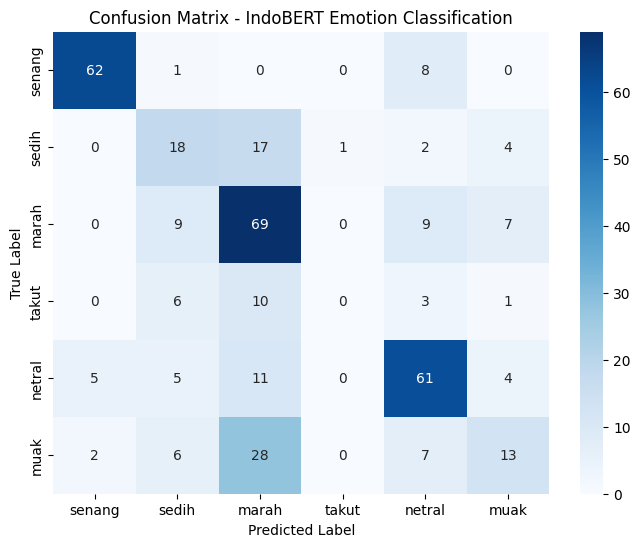

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Label mapping (urutan sesuai label_encoded)
labels = ['senang', 'sedih', 'marah', 'takut', 'netral', 'muak']

# Confusion Matrix
cm = confusion_matrix(val_labels_bert, val_preds_bert)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - IndoBERT Emotion Classification")
plt.show()


In [ ]:
import pandas as pd
from collections import Counter

# Salin data validasi dan tambahkan hasil prediksi IndoBERT
val_df_bert = val_df.copy().reset_index(drop=True)
val_df_bert['predicted'] = val_preds_bert

# Mapping ID label ke nama emosi
label_id_to_str = {
    0: 'senang',
    1: 'sedih',
    2: 'marah',
    3: 'takut',
    4: 'netral',
    5: 'muak'
}

# Hitung jumlah masing-masing label hasil prediksi IndoBERT
pred_counts_bert = Counter(val_df_bert['predicted'])
top5_bert = pred_counts_bert.most_common(5)

print("\n🔍 Hasil Prediksi Model: IndoBERT")
print("\n🔝 Top 5 Emosi (Prediksi IndoBERT):")
for label_id, count in top5_bert:
    emosi = label_id_to_str[label_id]
    print(f"{emosi}: {count} data")

# Tampilkan contoh kalimat dari masing-masing emosi
print("\n📌 Contoh Kalimat dari Prediksi IndoBERT:")
for label_id, _ in top5_bert:
    emosi = label_id_to_str[label_id]
    contoh_texts = val_df_bert[val_df_bert['predicted'] == label_id]['text'].head(5).tolist()

    print(f"\nEmosi: {emosi.upper()}")
    for text in contoh_texts:
        print(f"- {text}")



🔍 Hasil Prediksi Model: IndoBERT

🔝 Top 5 Emosi (Prediksi IndoBERT):
marah: 135 data
netral: 90 data
senang: 69 data
sedih: 45 data
muak: 29 data

📌 Contoh Kalimat dari Prediksi IndoBERT:

Emosi: MARAH
- Setelah update malah ngacoo, download pay slip malah closing aplikasinya
- Jgn keseringan mnt update dong bos
- Masa download payslip kaga bisa,, kalo ga server penuh force close.. tolong diperbaiki.
- Sangat sulit untuk log in,padahal tiap hari harus ngecek absensi
- SERVER SERING DOWN, GAK BISA LOGIN, MENU E VOUCHER DATA NOT FOUND, E PAYSLIP GA MUNCUL

Emosi: NETRAL
- Top
- Untuk kalender digitalnya tolong disesuaikan,sudah 2024 kok di aplikasi masih 2023
- Masih harus banyak perbaikan
- Ganti yamaha mobile z pak...
- ok

Emosi: SENANG
- Memudahkan
- Sangat membantu
- good
- Good
- Praktis.kapan dan dimana saja administrasi terkontrol.

Emosi: SEDIH
- Dear tim IT ahm,,,cb d buat notif ketika scan in dan out,,krna klo cek d apknya loading ke servernya lamaaaa,,krna kesibukan dan kbut